# Training demo notebook

In [ ]:
# nasty hack for Colab
![ -n $COLAB_RELEASE_TAG ] && git clone -b madziejm-dev https://github.com/madziejm/0nmt.git
![ -n $COLAB_RELEASE_TAG ] && pip install -r ./0nmt/requirements.txt
try:
  import google.colab
  import sys
  sys.path.insert(0, '/content/0nmt')
except Exception as e:
  print(e)

In [2]:
from pathlib import Path

import numpy as np
import pytorch_lightning as pl
import pytorch_lightning.callbacks as plc
import torch
import wandb
from icecream import ic
from matplotlib import pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers.wandb import WandbLogger
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.utils import download_from_url, extract_archive
from torchtext.vocab import vocab

from zeronmt.datasets import ParallelDataset
from zeronmt.models.datatypes import DimensionSpec, Language, Vectors
from zeronmt.models.seq2seq import Seq2SeqSupervised, Seq2SeqUnsupervised
from zeronmt.vectors import FastTextAligned

In [3]:
VOCAB_SIZE = int(4.5e4)  # we will use only 45K most-frequent words

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
special_tokens = ["<unk>", "<pad>", "<bos>", "<eos>"]
tokenizer = get_tokenizer("basic_english")  # keep it simple

## Unupervised training (cs-pl)

`src` means pl  
`tgt` means cs

### Word embeddings

In [4]:
MAPPING_PATH = Path("../best_mapping.pth")

In [5]:
mapping = torch.load(MAPPING_PATH)

# We will use vanilla FastText word embeddings and align them with mapping trained before.
src_vecs = FastTextAligned(
    "https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.cs.vec",
    mapping=None,
    special_toks=special_tokens,
    max_vectors=VOCAB_SIZE
)
tgt_vecs = FastTextAligned(
    "https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.pl.vec",
    mapping=mapping,
    special_toks=special_tokens,
    max_vectors=VOCAB_SIZE
)

In [6]:
opensubtitles_url = (
    "https://object.pouta.csc.fi/OPUS-OpenSubtitles/v2018/moses/cs-pl.txt.zip"
)

test_url = "https://object.pouta.csc.fi/OPUS-TED2020/v1/moses/cs-pl.txt.zip"

opensubtitles_filepaths = tuple(
    fp
    for fp in extract_archive(download_from_url(opensubtitles_url))
    if any(f in fp for f in ("OpenSubtitles.cs-pl.pl", "OpenSubtitles.cs-pl.cs"))
)

# does not work as we have two archives with the same name
# test_filepaths = tuple(
#     fp
#     for fp in extract_archive(download_from_url(test_url))
#     if any(f in fp for f in ("TED2020.cs-pl.pl", "TED2020.cs-pl.cs"))
# )
# hopefully this will work
test_filepaths = (
    ".data/TED2020.cs-pl.cs",
    ".data/TED2020.cs-pl.pl",
)

Shuffle the dataset so the sentences are not aligned.

In [7]:
!shuf --random-source=<(yes 42) -o .data/OpenSubtitles.cs-pl.cs .data/OpenSubtitles.cs-pl.cs
!shuf --random-source=<(yes 37) -o .data/OpenSubtitles.cs-pl.pl .data/OpenSubtitles.cs-pl.pl

#### Corpus sample
We see that the sample is not actually parallel.

In [8]:
!head -n 5 .data/OpenSubtitles.cs-pl.cs
!head -n 5 .data/OpenSubtitles.cs-pl.pl

Zavoláme k soudu a požádáme o odložení.
Pro člověka jako vy to musí být těžké, co?
Můžu říct, že čas strávený s váma je opravdu úžasný.
Není ho kam umístit.
Já tě neopustím.
To trzy bezpieczne.
To pieniądze.
Chyba tak.
Teraz nas interesujesz, później nie wiadomo.
Prześladowca. - Nie.


In [9]:
tgt_vocab = vocab(tgt_vecs.stoi, min_freq=0)
src_vocab = vocab(src_vecs.stoi, min_freq=0)

In [10]:
src_vocab.set_default_index(src_vocab["<unk>"])
tgt_vocab.set_default_index(tgt_vocab["<unk>"])

In [11]:
BATCH_SIZE = 64

# special tokens are prepended, so these indices are the same for both the languages
PAD_IDX = src_vocab["<pad>"]
BOS_IDX = src_vocab["<bos>"]
EOS_IDX = src_vocab["<eos>"]

### Dataset

We will use only one milion sentences from every corpus.  
TODO use more?

We reuse the `ParallelDataset` class for simpler implementation. The sentences returned by the class will not be parallel in fact as it gets files that are not aligned on sentence level. The class will return the same pair of src-tgt sentences for a given index though. We could improve on implementation to return a random pair from src and tgt instead of returning a pair that is fixed, yet not parallel.

In [12]:
train_val_data = ParallelDataset(
    *opensubtitles_filepaths,
    src_vocab,
    tgt_vocab,
    tokenizer,
    max_sentence_len=100,
    max_nsentence=1e6
)
test_data = ParallelDataset(
    *test_filepaths,
    src_vocab,
    tgt_vocab,
    tokenizer,
    max_sentence_len=100,
    max_nsentence=1e6
)

In [13]:
ic(len(train_val_data))
ic(len(test_data))

ic| len(train_val_data): 846993
ic| len(test_data): 150947


150947

[]

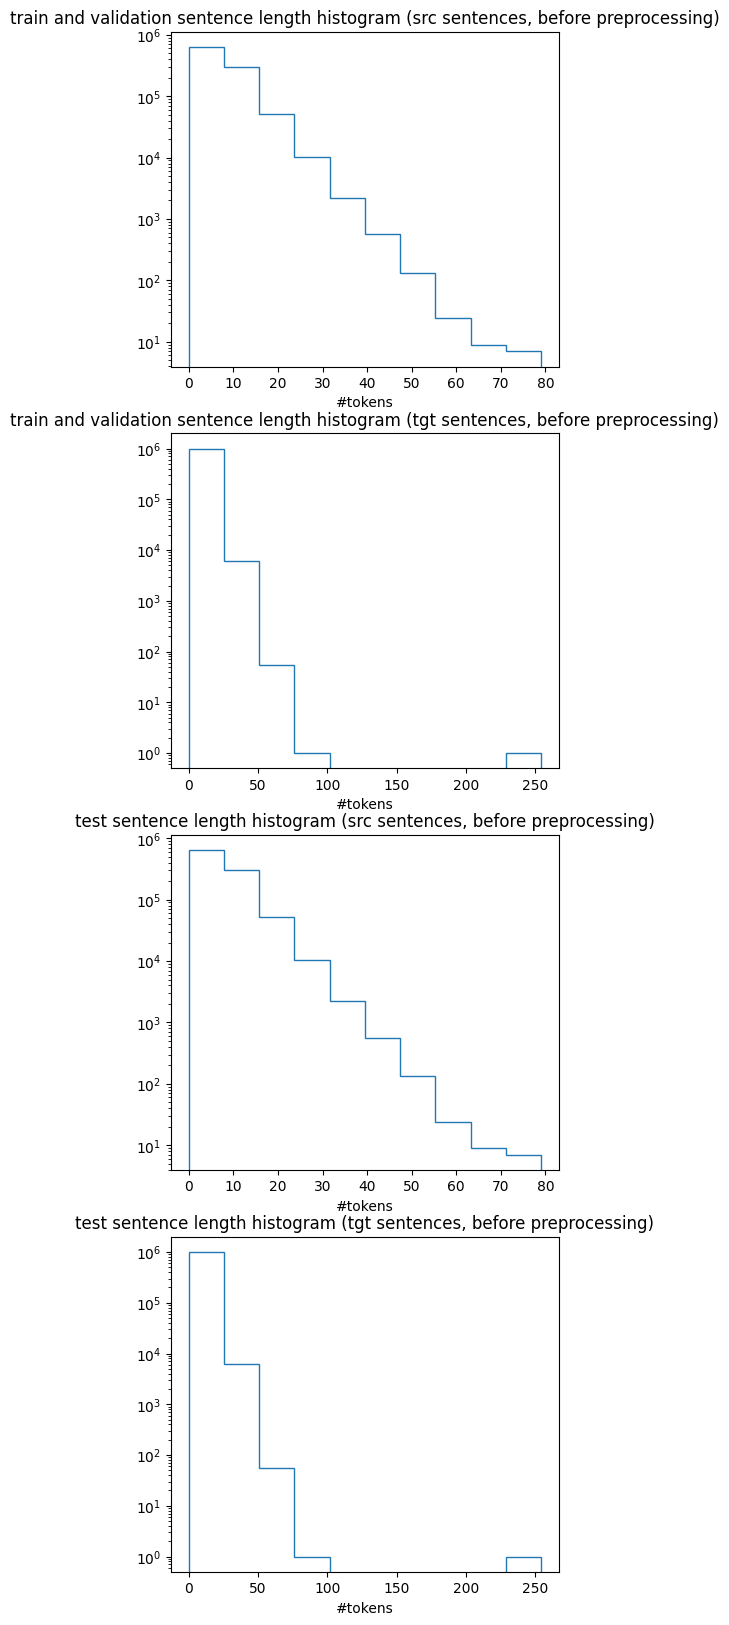

In [ ]:
fig, axs = plt.subplots(nrows=4, figsize=(5, 4 * 5))

for i, (hist_title, data) in enumerate(
    (("train and validation", train_val_data), ("test", test_data))
):
    counts, bins = np.histogram(data.lens_src)
    axs[2 * i].stairs(counts, bins)
    axs[2 * i].set_title(
        hist_title + " sentence length histogram (src sentences, before preprocessing)"
    )
    axs[2 * i].set_yscale("log")
    axs[2 * i].set_xlabel("count (log)")
    axs[2 * i].set_xlabel("#tokens")
    counts, bins = np.histogram(data.lens_tgt)
    axs[2 * i + 1].stairs(counts, bins)
    axs[2 * i + 1].set_title(
        hist_title + " sentence length histogram (tgt sentences, before preprocessing)"
    )
    axs[2 * i + 1].set_yscale("log")
    axs[2 * i + 1].set_xlabel("count (log)")
    axs[2 * i + 1].set_xlabel("#tokens")

    del data.lens_src
    del data.lens_tgt

plt.plot()

### Model

In [ ]:
ENC_HID_DIM = 64
DEC_HID_DIM = 64
ATTN_DIM = 8
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

In [ ]:
model = Seq2SeqSupervised(
    DEC_DROPOUT,
    ENC_DROPOUT,
    DimensionSpec(
        attention=ATTN_DIM,
        dec_hid=DEC_HID_DIM,
        enc_hid=ENC_HID_DIM,
        nspecial_toks=len(special_tokens),
    ),
    PAD_IDX,
    Vectors(src_vecs, tgt_vecs),
)

embedding_src.weight
embedding_tgt.weight
encoder.special_toks_embedding.weight
encoder.rnn.weight_ih_l0
encoder.rnn.weight_hh_l0
encoder.rnn.bias_ih_l0
encoder.rnn.bias_hh_l0
encoder.rnn.weight_ih_l0_reverse
encoder.rnn.weight_hh_l0_reverse
encoder.rnn.bias_ih_l0_reverse
encoder.rnn.bias_hh_l0_reverse
encoder.fc.weight
encoder.fc.bias
decoder.attention.attn.weight
decoder.attention.attn.bias
decoder.special_toks_embedding.weight
decoder.rnn.weight_ih_l0
decoder.rnn.weight_hh_l0
decoder.rnn.bias_ih_l0
decoder.rnn.bias_hh_l0
decoder.output_to_src.weight
decoder.output_to_src.bias
decoder.output_to_tgt.weight
decoder.output_to_tgt.bias


In [ ]:
model

Seq2SeqSupervised(
  (embedding_src): Embedding(627845, 300)
  (embedding_tgt): Embedding(1032581, 300)
  (encoder): Encoder(
    (embedding_src): Embedding(627845, 300)
    (embedding_tgt): Embedding(1032581, 300)
    (special_toks_embedding): Embedding(4, 300, padding_idx=1)
    (rnn): GRU(300, 64, bidirectional=True)
    (fc): Linear(in_features=128, out_features=64, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding_src): Embedding(627845, 300)
    (embedding_tgt): Embedding(1032581, 300)
    (attention): Attention(
      (attn): Linear(in_features=192, out_features=8, bias=True)
    )
    (special_toks_embedding): Embedding(4, 300, padding_idx=1)
    (rnn): GRU(428, 64)
    (output_to_src): Linear(in_features=492, out_features=627845, bias=True)
    (output_to_tgt): Linear(in_features=492, out_features=1032581, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (criterion): CrossEntropyLoss()
)

### Training

In [ ]:
def collate_batch(data_batch):
    src_batch, tgt_batch = [], []
    for src_item, tgt_item in data_batch:
        src_batch.append(
            torch.cat(
                [torch.tensor([BOS_IDX]), src_item, torch.tensor([EOS_IDX])], dim=0
            )
        )
        tgt_batch.append(
            torch.cat(
                [torch.tensor([BOS_IDX]), tgt_item, torch.tensor([EOS_IDX])], dim=0
            )
        )
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [ ]:
train_data, val_data = torch.utils.data.random_split(train_val_data, [0.8, 0.2])

In [ ]:
train_dl = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_batch,
    num_workers=0,
)
valid_dl = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_batch,
    num_workers=0,
)
test_dl = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_batch,
    num_workers=0,
)

In [ ]:
checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")
wandb_logger = WandbLogger(project="0nmt", log_model="all")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: 81bcd48a2 (0nmt). Use `wandb login --relogin` to force relogin


In [ ]:
trainer = pl.Trainer(
    gradient_clip_val=1.0,
    max_epochs=5,
    val_check_interval=0.5,
    callbacks=[plc.TQDMProgressBar(refresh_rate=5), checkpoint_callback],
    logger=wandb_logger,
)
trainer.fit(
    model,
    train_dataloaders=[train_dl],
    val_dataloaders=[valid_dl],
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | embedding_src | Embedding        | 188 M 
1 | embedding_tgt | Embedding        | 309 M 
2 | encoder       | Encoder          | 498 M 
3 | decoder       | Decoder          | 1.3 B 
4 | criterion     | CrossEntropyLoss | 0     
---------------------------------------------------
818 M     Trainable params
498 M     Non-trainable params
1.3 B     Total params
5,267.862 Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/maciej/.cache/pypoetry/virtualenvs/0nmt-W1lV1jMD-py3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/maciej/.cache/pypoetry/virtualenvs/0nmt-W1lV1jMD-py3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
wandb.finish()

## Supervised training (de-en)
This will serve as a baseline in a sense.

`src` means de  
`tgt` means eng

### Word embeddings

In [4]:
# Download aligned word embeddings for English and German.
tgt_vecs = FastTextAligned(
    "https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.en.align.vec",
    special_toks=special_tokens,
    max_vectors=VOCAB_SIZE,
)
src_vecs = FastTextAligned(
    "https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.de.align.vec",
    special_toks=special_tokens,
    max_vectors=VOCAB_SIZE,
)

In [5]:
tgt_vocab = vocab(tgt_vecs.stoi, min_freq=0)
src_vocab = vocab(src_vecs.stoi, min_freq=0)

In [6]:
src_vocab.set_default_index(src_vocab["<unk>"])
tgt_vocab.set_default_index(tgt_vocab["<unk>"])

In [7]:
ic(src_vecs.stoi["<unk>"])
ic(src_vecs.stoi["<pad>"])
ic(src_vecs.stoi["<bos>"])
ic(src_vecs.stoi["<eos>"])

ic| src_vecs.stoi["<unk>"]: 0
ic| src_vecs.stoi["<pad>"]: 1
ic| src_vecs.stoi["<bos>"]: 2
ic| src_vecs.stoi["<eos>"]: 3


3

In [8]:
BATCH_SIZE = 64

# special tokens are prepended, so these indices are the same for both the languages
PAD_IDX = src_vocab["<pad>"]
BOS_IDX = src_vocab["<bos>"]
EOS_IDX = src_vocab["<eos>"]

In [9]:
ic(PAD_IDX)
ic(BOS_IDX)
ic(EOS_IDX)

ic| PAD_IDX: 1
ic| BOS_IDX: 2
ic| EOS_IDX: 3


3

### Dataset

In [10]:
opensubtitles_url = (
    "https://object.pouta.csc.fi/OPUS-OpenSubtitles/v2018/moses/de-en.txt.zip"
)
test_urls = tuple(
    "https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/"
    + filename
    for filename in ("test_2016_flickr.de.gz", "test_2016_flickr.en.gz")
)

opensubtitles_filepaths = tuple(
    fp
    for fp in extract_archive(download_from_url(opensubtitles_url))
    if any(f in fp for f in ("OpenSubtitles.de-en.en", "OpenSubtitles.de-en.de"))
)

test_filepaths = [extract_archive(download_from_url(url))[0] for url in test_urls]

In [11]:
train_val_data = ParallelDataset(
    *opensubtitles_filepaths,
    src_vocab,
    tgt_vocab,
    tokenizer,
    max_sentence_len=100,
    max_nsentence=1e6
)
test_data = ParallelDataset(
    *test_filepaths,
    src_vocab,
    tgt_vocab,
    tokenizer,
    max_sentence_len=100,
    max_nsentence=1e6
)

In [12]:
ic(len(train_val_data))
ic(len(test_data))

ic| len(train_val_data): 930389
ic| len(test_data): 1000


1000

[]

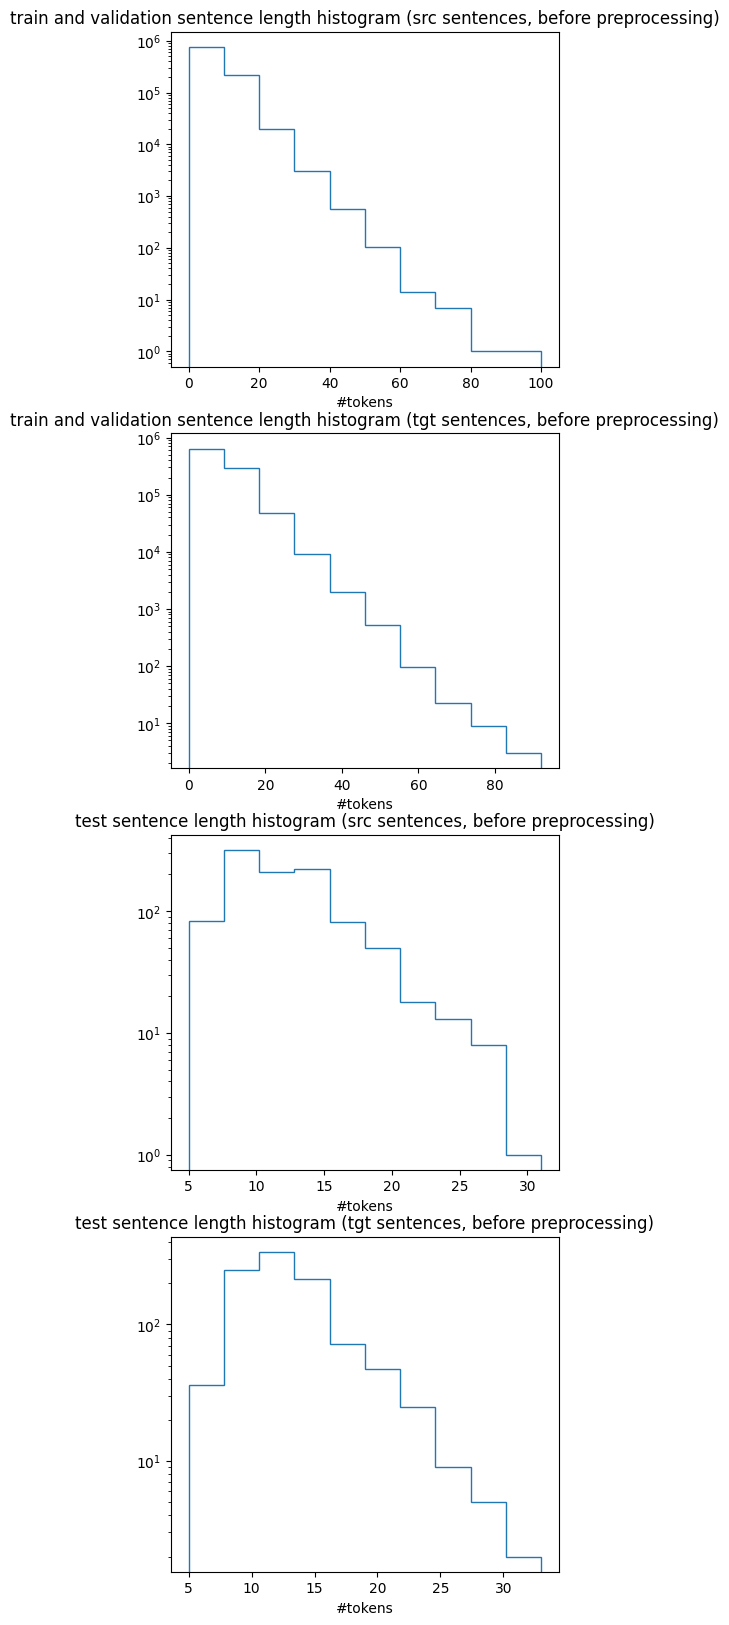

In [13]:
fig, axs = plt.subplots(nrows=4, figsize=(5, 4 * 5))

for i, (hist_title, data) in enumerate(
    (("train and validation", train_val_data), ("test", test_data))
):
    counts, bins = np.histogram(data.lens_src)
    axs[2 * i].stairs(counts, bins)
    axs[2 * i].set_title(
        hist_title + " sentence length histogram (src sentences, before preprocessing)"
    )
    axs[2 * i].set_yscale("log")
    axs[2 * i].set_xlabel("count (log)")
    axs[2 * i].set_xlabel("#tokens")
    counts, bins = np.histogram(data.lens_tgt)
    axs[2 * i + 1].stairs(counts, bins)
    axs[2 * i + 1].set_title(
        hist_title + " sentence length histogram (tgt sentences, before preprocessing)"
    )
    axs[2 * i + 1].set_yscale("log")
    axs[2 * i + 1].set_xlabel("count (log)")
    axs[2 * i + 1].set_xlabel("#tokens")

    del data.lens_src
    del data.lens_tgt

plt.plot()

### Model

In [14]:
ENC_HID_DIM = 64
DEC_HID_DIM = 64
ATTN_DIM = 8
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

In [15]:
model = Seq2SeqSupervised(
    DEC_DROPOUT,
    ENC_DROPOUT,
    DimensionSpec(
        attention=ATTN_DIM,
        dec_hid=DEC_HID_DIM,
        enc_hid=ENC_HID_DIM,
        nspecial_toks=len(special_tokens),
    ),
    PAD_IDX,
    Vectors(src_vecs, tgt_vecs),
)

embedding_src.weight
embedding_tgt.weight
encoder.special_toks_embedding.weight
encoder.rnn.weight_ih_l0
encoder.rnn.weight_hh_l0
encoder.rnn.bias_ih_l0
encoder.rnn.bias_hh_l0
encoder.rnn.weight_ih_l0_reverse
encoder.rnn.weight_hh_l0_reverse
encoder.rnn.bias_ih_l0_reverse
encoder.rnn.bias_hh_l0_reverse
encoder.fc.weight
encoder.fc.bias
decoder.attention.attn.weight
decoder.attention.attn.bias
decoder.special_toks_embedding.weight
decoder.rnn.weight_ih_l0
decoder.rnn.weight_hh_l0
decoder.rnn.bias_ih_l0
decoder.rnn.bias_hh_l0
decoder.output_to_src.weight
decoder.output_to_src.bias
decoder.output_to_tgt.weight
decoder.output_to_tgt.bias


In [16]:
model

Seq2SeqSupervised(
  (embedding_src): Embedding(45004, 300)
  (embedding_tgt): Embedding(45004, 300)
  (encoder): Encoder(
    (embedding_src): Embedding(45004, 300)
    (embedding_tgt): Embedding(45004, 300)
    (special_toks_embedding): Embedding(4, 300, padding_idx=1)
    (rnn): GRU(300, 64, bidirectional=True)
    (fc): Linear(in_features=128, out_features=64, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding_src): Embedding(45004, 300)
    (embedding_tgt): Embedding(45004, 300)
    (attention): Attention(
      (attn): Linear(in_features=192, out_features=8, bias=True)
    )
    (special_toks_embedding): Embedding(4, 300, padding_idx=1)
    (rnn): GRU(428, 64)
    (output_to_src): Linear(in_features=492, out_features=45004, bias=True)
    (output_to_tgt): Linear(in_features=492, out_features=45004, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (criterion): CrossEntropyLoss()
)

### Training

In [17]:
def collate_batch(data_batch):
    src_batch, tgt_batch = [], []
    for src_item, tgt_item in data_batch:
        src_batch.append(
            torch.cat(
                [torch.tensor([BOS_IDX]), src_item, torch.tensor([EOS_IDX])], dim=0
            )
        )
        tgt_batch.append(
            torch.cat(
                [torch.tensor([BOS_IDX]), tgt_item, torch.tensor([EOS_IDX])], dim=0
            )
        )
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [18]:
train_data, val_data = torch.utils.data.random_split(train_val_data, [0.8, 0.2])

In [19]:
ic(len(train_data))
ic(len(val_data))

ic| len(train_data): 744312
ic| len(val_data): 186077


186077

In [20]:
train_dl = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_batch,
    num_workers=0,
)
valid_dl = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_batch,
    num_workers=0,
)
test_dl = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_batch,
    num_workers=0,
)

In [21]:
checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")
wandb_logger = WandbLogger(project="0nmt", log_model="all")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: 81bcd48a2 (0nmt). Use `wandb login --relogin` to force relogin


In [22]:
trainer = pl.Trainer(
    gradient_clip_val=1.0,
    max_epochs=5,
    val_check_interval=0.5,
    callbacks=[plc.TQDMProgressBar(refresh_rate=5), checkpoint_callback],
    logger=wandb_logger,
)
trainer.fit(
    model,
    train_dataloaders=[train_dl],
    val_dataloaders=[valid_dl],
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | embedding_src | Embedding        | 13.5 M
1 | embedding_tgt | Embedding        | 13.5 M
2 | encoder       | Encoder          | 27.2 M
3 | decoder       | Decoder          | 71.5 M
4 | criterion     | CrossEntropyLoss | 0     
---------------------------------------------------
44.6 M    Trainable params
27.0 M    Non-trainable params
71.6 M    Total params
286.496   Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/maciej/.cache/pypoetry/virtualenvs/0nmt-W1lV1jMD-py3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/maciej/.cache/pypoetry/virtualenvs/0nmt-W1lV1jMD-py3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   0%|          | 0/11630 [00:00<?, ?it/s] 

/home/maciej/.cache/pypoetry/virtualenvs/0nmt-W1lV1jMD-py3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
wandb.finish()

### Prediction examples

In [ ]:
src_in = torch.tensor(
    [src_vocab[token] for token in tokenizer("<bos> ich liebe kartoffeln <eos>")]
).unsqueeze(1)
tgt_in = torch.tensor(
    [tgt_vocab[token] for token in tokenizer("<bos> i love potatoes <eos>")]
).unsqueeze(
    1
)  # actually unused

ic| src_in.shape: torch.Size([5, 1])
ic| src_in: tensor([[    2],
                    [   47],
                    [  969],
                    [15732],
                    [    3]])
ic| tgt_in.shape: torch.Size([5, 1])
ic| tgt_in: tensor([[    2],
                    [   32],
                    [  571],
                    [14391],
                    [    3]])


tensor([[    2],
        [   32],
        [  571],
        [14391],
        [    3]])

In [ ]:
output = model(
    src_in.to(device),
    tgt_in.to(device),
    Language.src,
    Language.tgt,
    teacher_forcing_ratio=0,
).cpu()
torch.set_printoptions(profile="full")
predicted_tokens = output.argmax(-1)
ic(predicted_tokens)
tgt_sent = " ".join([tgt_vocab.get_itos()[t] for t in predicted_tokens])
ic(tgt_sent)

ic| output.shape: torch.Size([5, 1, 50004])
ic| predicted_tokens.shape: torch.Size([5, 1])
ic| predicted_tokens: tensor([[   0],
                              [  25],
                              [6329],
                              [6329],
                              [6329]])
ic| [tgt_vocab.get_itos()[t] for t in predicted_tokens]: ['<unk>', 'it', 'su', 'su', 'su']


['<unk>', 'it', 'su', 'su', 'su']

In [ ]:
output = model(
    src_in,
    torch.tensor(tuple(tgt_vocab["<bos>"] for _ in src_in[:, 0])).unsqueeze(-1),
    Language.src,
    Language.tgt,
    teacher_forcing_ratio=0,
)
# torch.set_printoptions(profile="full")
predicted_tokens = output.argmax(-1)
ic(output.shape)
ic(predicted_tokens.shape)
ic(predicted_tokens)
ic([tgt_vocab.get_itos()[t] for t in predicted_tokens])

ic| output.shape: torch.Size([5, 1, 50004])
ic| predicted_tokens.shape: torch.Size([5, 1])
ic| predicted_tokens: tensor([[    0],
                              [   25],
                              [28431],
                              [28431],
                              [28431]])
ic| [tgt_vocab.get_itos()[t] for t in predicted_tokens]: ['<unk>', 'it', 'agonist', 'agonist', 'agonist']


['<unk>', 'it', 'agonist', 'agonist', 'agonist']

In [ ]:
for i, (src_in, tgt_in) in enumerate(valid_dl):
    if i >= 10:
        break
    src_in = src_in[:, 0].unsqueeze(-1)  # first item in the batch only
    tgt_in = tgt_in[:, 0].unsqueeze(-1)  # first item in the batch only
    output = model(
        src_in.to(device),
        tgt_in.to(device),
        Language.src,
        Language.tgt,
        teacher_forcing_ratio=0,
    ).cpu()
    torch.set_printoptions(profile="full")
    predicted_tokens = output.argmax(-1)

    src_sent = " ".join(src_vocab.get_itos()[t] for t in src_in[:12])
    tgt_sent = " ".join(tgt_vocab.get_itos()[t] for t in predicted_tokens[:12])
    ic(src_sent)
    ic(tgt_sent)

ic| src_in.shape: torch.Size([23, 128])
ic| tgt_in.shape: torch.Size([25, 128])
ic| src_in.shape: torch.Size([23, 1])
ic| tgt_in.shape: torch.Size([25, 1])
ic| src_in[:, 0]: tensor([   2, 1695,   21,   34,   66,    8,    0,    5,  203,   32,    8,    0,
                             4,    3,    1,    1,    1,    1,    1,    1,    1,    1,    1])
ic| tgt_in[:, 0]: tensor([    2,    11,    29,    17,     6, 25597,     4,     6, 27690,     5,
                              3,     1,     1,     1,     1,     1,     1,     1,     1,     1,
                              1,     1,     1,     1,     1])
ic| output.shape: torch.Size([25, 1, 50004])
ic| predicted_tokens.shape: torch.Size([25, 1])
ic| predicted_tokens[:, 0]: tensor([ 0, 25, 35, 25,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
                                     1,  1,  1,  1,  1,  1,  1])
ic| [src_vocab.get_itos()[t] for t in src_in[:12]]: ['<bos>',
                                                     'gott',
          

['<unk>',
 'it',
 'his',
 'it',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']